In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import os
from torch.utils.data import random_split
import numpy as np

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL

# scale augmentation

In [66]:
## make shorter side of image to [256, 480] for scale augmentation
def shorter_side_resize(img) :
    width, height = img.size
    print(f"before : {width, height}")
    # resized하고 나서도, 한 면이 224보다 작으면 randomcrop(224)를 할 수 없으니
    if width < 224 and height < 224 :
        if width < height :
            height = 224
            width = round(height*(224/width))
            img = transforms.Resize((height, width))(img)
            print(f"after 1 : {round(height*(224/width)), 224}")
        else :
            height = round(width*(224/height))
            width = 224
            img = transforms.Resize((height, width))(img)
            print(f"after 1 : {224, round(width*(224/height))}")
    random = np.random.randint(256, 480)
    print(f"random : {random}")
    if width < height :
        print(f"after 2 : {random, height}")
        return transforms.Resize((height, random))(img) # Resize((h, w))
    else :
        print(f"after 2 : {width, random}")
        return transforms.Resize((random, width))(img) # Resize((h, w))

trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    transform = transforms.Compose([   
        shorter_side_resize,
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])   
)

(200, 150)


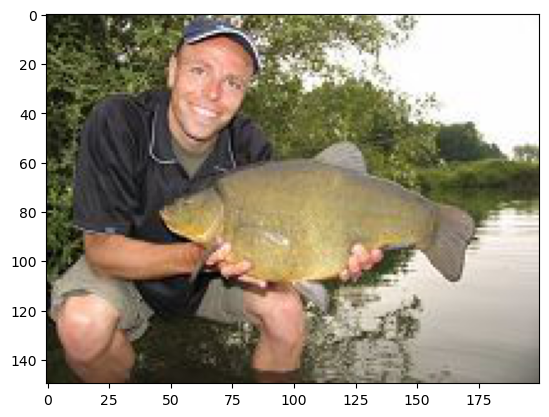

before : (200, 150)
after 1 : (224, 168)
random : 339
after 2 : (339, 299)
(224, 224)


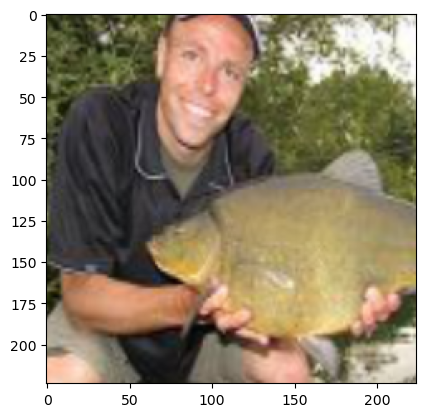

In [67]:
sample_img = PIL.Image.open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train/n01440764/n01440764_10027.JPEG')
print(sample_img.size)
# visualize
plt.imshow(sample_img)
plt.show()

# make shorter side [256, 480]
sample_img = shorter_side_resize(sample_img)
sample_img = transforms.RandomCrop(224)(sample_img)
print(sample_img.size)
# visualize
plt.imshow(sample_img)
plt.show()

In [68]:
# visualization of the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
for i, data in enumerate(train_loader, 0):
    inputs, classes = data
    print(f"inputs : {inputs.size()}")
    print(f"classes : {classes}")
    imshow(torchvision.utils.make_grid(inputs))
    break

NameError: name 'train_loader' is not defined

# TenCrop

MY_Resnet34_exp1 best model TenCrop test

In [11]:
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val',
    transform=transforms.Compose([
        # 10-crop
        # transforms.Resize(256),
        transforms.Resize((256 + 480) // 2),
        transforms.TenCrop(224),    
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [12]:
mini_batch_size = 64

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=8, pin_memory=True
)

In [13]:
class BuildingBlock(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = 1      # In block without down_sampling, stride is 1.
        self.kernel_size = 3 # In block without down_sampling, kernel_size is 3.
        self.padding = 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x) : 
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity # identity mapping
        out = self.relu2(out)
        
        return out

In [14]:
class BuildingBlockWithDownSample(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = 3
        self.down_sampling_kernel_size = 1
        self.conv1_stride = 2 # In block with down_sampling, conv1's stride is 2.
        self.conv2_stride = 1 # In block with down_sampling, conv2's stride is 1.
        self.padding = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv1_stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv2_stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        # (projection shortcut) : H, W of activation map are down_sampled, C of activation map is up_sampled
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.down_sampling_kernel_size, stride=self.conv1_stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
    
    def forward(self, x) : 
        identity = self.downsample(x) # projection shortcut 
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity       # projection shortcut
        out = self.relu2(out) # block output
        
        return out
        
        

In [15]:
# Class ResNet34 > Class BuildingBlock, Class BuildingBlockWithDownSample
class MyResNet34(nn.Module) :
    def __init__(self) :
        super().__init__()
        num_classes : int = 1000
        
        self.layer0 = nn.Sequential( # 2
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), # affine : True ? gamma, beta, track_running_stats : True ? running_mean, running_var
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = nn.Sequential( # 3 * 2 = 6
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
        )
        self.layer2 = nn.Sequential( # 4 * 2 = 8
            BuildingBlockWithDownSample(64, 128), # projection shortcut
            BuildingBlock(128, 128), # identity mapping
            BuildingBlock(128, 128), # identity mapping
            BuildingBlock(128, 128), # identity mapping
        )
        self.layer3 = nn.Sequential( # 5 * 2 = 10
            BuildingBlockWithDownSample(128, 256), # projection shortcut
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
        )
        self.layer4 = nn.Sequential( # 3 * 2 = 6
            BuildingBlockWithDownSample(256, 512), # projection shortcut
            BuildingBlock(512, 512),
            BuildingBlock(512, 512),
        )
        self.layer5 = nn.Sequential( # 2
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes, bias=True),
        )
        
    def forward(self, x) : 
        ## Input size : 224 x 224 x 3 -> 112 x 112 x 64 -> Output size : 56 x 56 x 64
        x = self.layer0(x)
        ## Input size : 56 x 56 x 64, Output size : 56 x 56 x 64
        x = self.layer1(x)
        ## Input size : 56 x 56 x 64, Output size : 28 x 28 x 128
        x = self.layer2(x)
        ## Input size : 28 x 28 x 128, Output size : 7 x 7 x 512
        x = self.layer3(x)
        ## Input size : 7 x 7 x 512, Output size : 1 x 1 x 512
        x = self.layer4(x)
        ## Input size : (mini_batch_size) x 1 x 1 x 512 ->  1 x 1 x 512 -> Output size : 1 x 1 x 1000
        x = self.layer5(x)
        
        return x        
        

In [16]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = MyResNet34()

# load pre-trained model
model.load_state_dict(torch.load("./My_ResNet34_exp4_Checkpoint/best_model.pth"))

<All keys matched successfully>

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

criterion = nn.CrossEntropyLoss()

num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)
print(f"num_val_batch : {num_val_batch}")

cuda:0
num_val_batch : 782


In [18]:
# best model에 대한 top-1 accuracy 계산
model.load_state_dict(torch.load("./My_ResNet34_exp4_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")


val loss : 1.1186861605443004
val acc : 73.006%
error rate : 26.994%


In [19]:
# best model에 대한 top-5 accuracy 계산, TenCrop
model.load_state_dict(torch.load("./My_ResNet34_exp4_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.topk(5, 1, True, True)
        total += target.size(0)
        correct += predicted.eq(target.view(-1, 1).expand_as(predicted)).sum().item()     

print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 1.118527201130567
val acc : 91.678%
error rate : 8.322%


: 